<a href="https://colab.research.google.com/github/ColsonXu/C-on-TI-84-Plus-CE/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection from Chest X-Ray

Detection of lesions from X-Ray has always been a difficult topic to tackle. Doctors train for many years so that they can tell weather there is something wrong with the patient. It has always been the way medical imagery worked in hospitals. However, recent experiments discovered that deep learning, a branch of artificial intellegence, is able to detect abnormalities from images of X-Ray faster and more accurate than a doctor can do. With this in mind, and considering the recent SARS-COV-2 outbreak, I am designing a deep learning model to detect pneumonia cases from X-Ray.

## Data
Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
http://dx.doi.org/10.17632/rscbjbr9sj.2

Liscense: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)

In [ ]:
!pip install jovian --upgrade -q
import os
import torch
import shutil
import jovian
import zipfile
import torchvision
import torch.nn as nn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets.utils import download_url

In [ ]:
project_name='pneumonia-detection'

## Download the Dataset

In [ ]:
dataset_url = 'https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497'
download_url(dataset_url, '.', 'data.zip')

Using downloaded and verified file: .\data.zip


In [ ]:
with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.startswith('chest'):
            zip_ref.extract(file, './data')

In [ ]:
data_dir = './data/chest_xray'

## Cleaning Up the Data

The X-Ray data is split into a training folder and a test folder. Under each of those folders, there are two folders called 'NORMAL' and 'PNEUMONIA'. It also contains '.DS._Store' files which we do not want.

In [ ]:
for parent, dirnames, filenames in os.walk(data_dir):
    for fname in filenames:
        if fname.endswith('Store'):
            os.remove(os.path.join(parent, fname))

After some inspection I discovered that in the 'PNEUMONIA' folders, images are labeled either 'virus' or 'bacteria' indicating the cause of pneumonia. I want the model to be able to identify the cause as well. To achieve that, I first need to seperate those images into two folders.

In [ ]:
def classify_image(dir):
    # define directories
    PNEUMONIA = os.path.join(dir, 'PNEUMONIA')
    VIRUS = os.path.join(dir, 'VIRUS')
    BACTERIA = os.path.join(dir, 'BACTERIA')
    
    # create folders if doesn't exist
    for path in [PNEUMONIA, VIRUS, BACTERIA]:
        if not os.path.exists(path):
            os.mkdir(path)

    # move files into corresponding folders
    for file in os.listdir(PNEUMONIA):
        if 'virus' in file:
            shutil.move(os.path.join(PNEUMONIA, file), os.path.join(VIRUS, file))
        elif 'bacteria' in file:
            shutil.move(os.path.join(PNEUMONIA, file), os.path.join(BACTERIA, file))
    
    # delete empty folder
    if os.path.exists(PNEUMONIA):
        shutil.rmtree(PNEUMONIA)

In [ ]:
classify_image(os.path.join(data_dir, 'train'))
classify_image(os.path.join(data_dir, 'test'))

## Pre-processing
After cleaning up the data, I immedietly discovered a problem. That is the X-Ray images have vastly different dimensions, some are 832x416, and some are 1680x1328. This is bit of a challenge because they all need to be of the same size (resolution and aspect ratio) before feeding into the model. To process the image, I plan to use `torchvision.transform.functional.resize()` to bring the short side of image to a certain size and then center crop the outputs.

In [ ]:
def normalize():
    return torchvision.transforms.Compose([
               torchvision.transforms.Grayscale(),
               torchvision.transforms.Resize(400),
               torchvision.transforms.CenterCrop(400),
               torchvision.transforms.ToTensor()
           ])

In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=normalize())

In [ ]:
img, lable = dataset[0]
img.shape

torch.Size([1, 400, 400])

## Validation & Training Datasets

I want another set of data for validation purposes. To do that, I will use `random_split` to create another batch of data containing 500 X-Ray images for each normal and infected cases. In order for the validation set to be consistant, I will set a random seed for `random_split`.

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
val_size = 100
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(5132, 100)

In [ ]:
batch_size = 100

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, pin_memory=True)

## Exploring the Data
The training data consists of 4732 X-Ray images of people who are healthy, infected by bacteria, and infected by virus. Let's take a look at some sample images.

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    img = torchvision.transforms.functional.to_pil_image(img)
    plt.imshow(img)

Label:  BACTERIA (0)


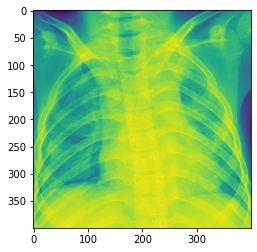

In [ ]:
show_example(*dataset[290])

In [ ]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


## Defining the Model
I am using a Convolutional Neural Network, ResNet to be exact, to solve the problem. The 2D convolution is just a kernel (a matrix of weights) scanning through an image and perform element-wise multiplication with the part of the image it's currently on and summing up the results into a single pixel.
![Kernel](https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)
The convolutional layer transforms a image into a multi-channel feature map. Then we use a pooling layer to downsize the "image". We repeat the process until we have a fully connected layer. We keep increasing the channel (features) of the image because it is where the logic of CNN happens.
![CNN](https://i.imgur.com/KKtPOKE.png)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class PDCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        kernel = 3
        stride = 1
        padding = 1
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=kernel, padding=padding),
            nn.ReLU(),
            nn.Conv2d(32, 128, kernel_size=kernel, stride=stride, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 270, kernel_size=kernel, stride=stride, padding=padding),
            nn.ReLU(),
#             nn.Conv2d(270, 270, kernel_size=kernel, stride=stride, padding=padding),
#             nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(270, 400, kernel_size=kernel, stride=stride, padding=padding),
            nn.ReLU(),
#             nn.Conv2d(400, 400, kernel_size=kernel, stride=stride, padding=padding),
#             nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(3000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 250),
            nn.ReLU(),
            nn.Linear(250, 3),
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = PDCnnModel()

We will now check if our model works properly by feeding in a batch of data.

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

To enable GPU acceleration, I will write a helper class to wrap the current `DataLoader` to transfer the data to GPU when called.

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

In [ ]:
torch.cuda.empty_cache()

## Training the Model

In [ ]:
@torch.no_grad() # tells pytorch not to track gradients
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
evaluate(model, val_dl)

Initially we can achieve an accuracy of approximately 26%. Now we are going to start training the model. I have selected a Adam as the optimizer.

In [ ]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)